In [1]:
import argparse
import sys
import os
import logging
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import norm
from scipy.optimize import minimize

sys.path.insert(0, '../network')
from network import *
from transfer_functions import ErrorFunction, ReLU, LIF 
from sequences import Sequence
from connectivity import *
from noise import WhiteNoise

sys.path.insert(0, '../scripts')
from simulation import *

import matplotlib
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)

In [2]:
exc_phi_relu = ReLU(g=12)
inh_phi_relu = ReLU(g=20)

In [3]:
phi_bounds = {
    "lower": -5,
    "upper": 40,
    "count": int(2e3)
}

Fit the LIF transfer function to the ReLU function (excitatory)

sigma: 2.1972
thresh: 3.9040


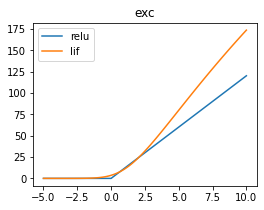

In [4]:
tau_mem = 1e-2

def fun(params):
    sigma, thresh = params
    x = np.linspace(-0,2.5,100)
    r1 = LIF(taum=tau_mem, sigma=sigma, thresh=thresh, reset=0, taurp=1e-3, bounds=phi_bounds).phi(x)
    r2 = exc_phi_relu.phi(x)
    return np.sqrt(np.sum((r1-r2)**2))

res = minimize(fun, x0=(1,3), bounds=((1,None), (0,None)))
params = res.x
sigma, thresh_exc = params

fig, ax = plt.subplots(1,1,figsize=(4,3))
x = np.linspace(-5,10,100)
exc_phi_lif = LIF(taum=tau_mem, sigma=sigma, thresh=thresh_exc, reset=0, taurp=1e-3, bounds=phi_bounds)
ax.plot(x, exc_phi_relu.phi(x), label="relu")
ax.plot(x, exc_phi_lif.phi(x), label="lif")
ax.set_title("exc")
ax.legend();
print("sigma: %.4f\nthresh: %.4f" % (sigma, thresh_exc))



Fit the LIF transfer function to the ReLU function (inhibitory)

sigma: 3.2048
thresh: 6.6401


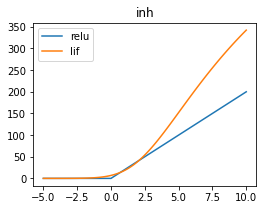

In [5]:
tau_mem = 2e-3

def fun(params):
    sigma, thresh = params
    x = np.linspace(-0,2.5,100)
    r1 = LIF(taum=tau_mem, sigma=sigma, thresh=thresh, reset=0, taurp=1e-3, bounds=phi_bounds).phi(x)
    r2 = inh_phi_relu.phi(x)
    return np.sqrt(np.sum((r1-r2)**2))

res = minimize(fun, x0=(1,3), bounds=((1,None), (0,None)))
params = res.x
sigma, thresh_inh = params
print(sigma, thresh_inh)

# Manually tweak parameters
sigma = 3.2048
thresh_inh = 6.6401

fig, ax = plt.subplots(1,1,figsize=(4,3))
x = np.linspace(-5,10,100)
inh_phi_lif = LIF(taum=tau_mem, sigma=sigma, thresh=thresh_inh, reset=0, taurp=1e-3, bounds=phi_bounds)
ax.plot(x, inh_phi_relu.phi(x), label="relu")
ax.plot(x, inh_phi_lif.phi(x), label="lif")
ax.set_title("inh")
ax.legend();
print("sigma: %.4f\nthresh: %.4f" % (sigma, thresh_inh))

Calculate J_EI and J_IE

In [6]:
N_E = 20000
N_I = 5000

P, S = 32, 1

c_EE = p = 0.04
c_IE = 0.04
c_EI = 0.04

K_EE = N_E*c_EE
K_EI = N_E*c_EI
K_IE = N_I*c_IE
alpha = S*(P-1)/K_EE

A = 4.25
x_f, q_f = 1.5, 0.8
x_g, q_g = x_f, norm.cdf(x_f)

# Linear transformation
g_w, o_w = 1.,  -0.0038

def f(x, q_f, x_f):
    if x >= x_f: return q_f
    else:        return -(1-q_f)

def g(x, q_g, x_g):
    if x >= x_g: return q_g
    else:        return -(1-q_g)

E_f = norm.expect(lambda x: f(x, q_f, x_f))
gamma   = norm.expect(lambda x: f(x, q_f, x_f)**2) * norm.expect(lambda x: g(x, q_g, x_g)**2)

# Linear transformation
w       = lambda x: np.clip(g_w * x + o_w, a_min=0, a_max=np.inf)
w_prime = lambda x: np.clip(g_w + o_w, a_min=0, a_max=np.inf)
def w_prime(x):
    if x > o_w:
        return g_w
    else:
        return 0

w_ee_bar       = norm.expect(lambda x: w(A*np.sqrt(alpha*gamma)*x))
w_ee_bar_prime = norm.expect(lambda x: w_prime(A*np.sqrt(alpha*gamma)*x))
w_ee_bar_2     = norm.expect(lambda x: w(A*np.sqrt(alpha*gamma)*x)**2)

print("w_ee_bar", w_ee_bar)
print("w_ee_bar_prime", w_ee_bar_prime)
print("w_ee_bar_2", w_ee_bar_2)

# Values from data_b.py and data_c.py
A_IE = 8/4
A_EI = 1/160.*4

J_IE  = w_ee_bar * c_IE / K_IE
J_EI  = - c_EI / np.sqrt(K_EI)

print("J_IE", J_IE)
print("J_EI", J_EI)

J_I_1 = J_IE * J_EI * N_I * N_E
J_I_2 = -np.sqrt(K_EE)*w_ee_bar

print("J_I_1", J_I_1)
print("J_I_2", J_I_2)

# Values from data_c.py
conversion_factor_exc = 5.167
conversion_factor_inh = 3.089

tau_syn_exc = 0.02
tau_syn_inh = 0.005

J_IE_ij = A_IE * w_ee_bar / K_IE
J_EI_ij = - A_EI / np.sqrt(K_EI)

J_IE_ij_mV = A_IE * w_ee_bar / K_IE * conversion_factor_inh
J_EI_ij_mV = - A_EI / np.sqrt(K_EI) * conversion_factor_exc

print("")
print("J_IE_ij", J_IE_ij)
print("J_EI_ij", J_EI_ij)
print("J_IE_ij (mV)", J_IE_ij_mV/tau_syn_inh)
print("J_EI_ij (mV)", J_EI_ij_mV/tau_syn_exc)

w_ee_bar 0.02173208150847901
w_ee_bar_prime 0.5256270607682211
w_ee_bar_2 0.0015751390325396198
J_IE 4.346416301695802e-06
J_EI -0.001414213562373095
J_I_1 -0.6146760881577713
J_I_2 -0.6146760881577713

J_IE_ij 0.0002173208150847901
J_EI_ij -0.0008838834764831844
J_IE_ij (mV) 0.13426079955938333
J_EI_ij (mV) -0.2283512961494307


Generate patterns

In [7]:
# Generate sequences
P = 32
patterns = np.random.RandomState(seed=1).normal(0,1,size=(P,N_E))
sequence = Sequence()
sequence.inputs = patterns

Build EE connectivity (two populations)

In [8]:
# Structural connectivity
k = np.random.RandomState(seed=2).binomial(N_E, p, size=N_E)
ji = build_ji(k, N_E)

100%|██████████| 20000/20000 [00:10<00:00, 1896.90it/s]


In [9]:
# Store pattern associations using the threshold plasticity rule
plasticity = ThresholdPlasticityRule(x_f=1.5, q_f=0.8)
indptr, indices, data_p0 = store_associations(
    patterns, plasticity.f, plasticity.g, ji, K_EE, p=0)
_, _, data_p1 = store_associations(
    patterns, plasticity.f, plasticity.g, ji, K_EE, p=1)

100%|██████████| 20000/20000 [00:05<00:00, 3897.99it/s]


Simulate

In [28]:
# Excitatory LIF parameters
sigma_lif_E = thresh_exc/2.

# Inhibitory LIF parameters
sigma_lif_I = thresh_inh/2.

# Set desired thresholds, and compute conversion factors
thresh_exc_desired = 20 # mV
thresh_inh_desired = 20 # mV
conversion_factor_exc = thresh_exc_desired/thresh_exc # mV
conversion_factor_inh = thresh_inh_desired/thresh_inh # mV

# Set desired "reversal potential"
v_exc_lower_bound = -10

N_E = 20000
N_I = 5000

T = 2
dt = 1e-3

exc = SpikingNeurons(
    N=20000,
    tau_mem=0.01,
    tau_syn=0.02,
    thresh=thresh_exc*conversion_factor_exc,
    reset=0,
    name="exc")
inh = SpikingNeurons(
    N=5000, 
    tau_mem=0.002,
    tau_syn=0.005,
    thresh=thresh_inh*conversion_factor_inh,
    reset=0,
    name="inh") 

exc_phi = ReLU(g=12).phi
inh_phi = ReLU(g=20).phi

# Build connectivity
conn_EE = Connectivity()
conn_IE = SparseConnectivity(source=exc, target=inh, p=0.04, fixed_degree=False)
conn_EI = SparseConnectivity(source=inh, target=exc, p=0.04, fixed_degree=False)
conn_II = SparseConnectivity(source=inh, target=inh, p=0.04, fixed_degree=False)
K_IE, K_EI, K_II = conn_IE.K, conn_EI.K, conn_II.K

# Plasticity rule
plasticity = ThresholdPlasticityRule(x_f=1.5, q_f=0.8)

print("Excitatory rescaling factor", conversion_factor_exc)
print("Inhibitory rescaling factor", conversion_factor_inh)

# Build IJ
conn_EE.ij = [[] for _ in range(exc.size)]
for row_idx, col_idxs in enumerate(ji):
    for col_idx in col_idxs:
        conn_EE.ij[col_idx].append(row_idx)

# Synaptic transform
synapse = RectifiedSynapse(K_EE, K_IE, K_EI, K_II, 
    alpha=P/float(K_EE),
    plasticity=plasticity,
    A=A,
    g=1.0,
    o=-0.0038)

# Store sequences (adjust EE weights)
data_p1_copy = np.asarray(data_p1).copy()
data_p0_copy = np.asarray(data_p0).copy()
reweight(indptr, indices, data_p1_copy, # Asymmetric
         1, N_E, w_11=1, w_12=1, w_21=0, w_22=0) # 1, 1, 0, 0
reweight(indptr, indices, data_p0_copy, # Symmetric
         1, N_E, w_11=0, w_12=0, w_21=1, w_22=1) # 0, 0, 1, 1
data = synapse.h_EE(data_p1_copy*K_EE + data_p0_copy*K_EE)
W = cp.sparse.csr_matrix(
    (cp.asarray(data), cp.asarray(indices), cp.asarray(indptr)),
    shape=(N_E,N_E),
    dtype=cp.float32)
conn_EE.W = W.get()
conn_EE.K = K_EE

# Specify other connectivity
A_IE = 8/4.
A_EI = 1/160.*4
conn_IE.set_all(synapse.h_IE(A_IE))
conn_EI.set_all(synapse.h_EI(A_EI))
conn_II.set_all(synapse.h_II(0))

conn_IE.scale_all(conversion_factor_inh)
conn_EI.scale_all(conversion_factor_exc)
conn_II.scale_all(conversion_factor_inh)
conn_EE.scale_all(conversion_factor_exc)

net = SpikingNetwork(exc, inh, conn_EE, conn_IE, conn_EI, conn_II)

# Simulate
s0_exc = exc_phi(conversion_factor_exc*plasticity.f(patterns[0,:]))
v0_exc = np.zeros_like(patterns[0,:])
s0_inh = np.zeros(inh.size)
v0_inh = np.zeros(inh.size)
s0_inh[:] = np.mean(s0_exc)

#Slow 
mu_E_1 = -1.5
mu_E_2 = 0.5

# Fast
#mu_E_1 = 0.75
#mu_E_2 = -0.75

net.simulate_two_pop(
    T,
    s0_exc,
    v0_exc,
    s0_inh,
    v0_inh,
    sigma_lif_E=sigma_lif_E*conversion_factor_exc,
    sigma_lif_I=sigma_lif_I*conversion_factor_inh,
    mu_E_1=mu_E_1,
    mu_E_2=mu_E_2,
    v_exc_lower_bound=v_exc_lower_bound)

# Overlaps
overlaps = sequence.overlaps(net, exc, plasticity=plasticity, spikes=True, correlation=True)
M = np.mean(net.exc.state**2, axis=0)

# Excitatory voltage/rates/spikes
v_exc = net.exc.state[:,:,1].astype(np.float16)
rate_exc = net.rates(net.exc).astype(np.float16)
spks_exc = net.exc.spikes

# Inhibitory voltage/rates/spikes
v_inh = net.inh.state[:,:,1].astype(np.float16)
rate_inh = net.rates(net.inh).astype(np.float16)
spks_inh = net.inh.spikes

INFO:connectivity:Building connections from exc to inh
INFO:connectivity:Building connections from inh to exc
INFO:connectivity:Building connections from inh to inh


Excitatory rescaling factor 5.12298934892125
Inhibitory rescaling factor 3.012002831282661


20000it [00:00, 109143.96it/s]
20000it [00:00, 111498.15it/s]
INFO:network:Integrating network dynamics


  0%|          | 0/1999 [00:00<?, ?it/s]

INFO:sequences:Computing correlations
100%|██████████| 32/32 [01:03<00:00,  2.00s/it]


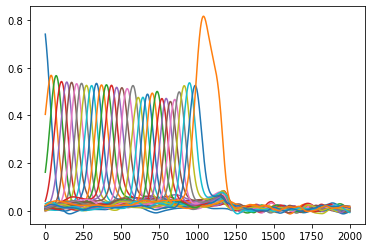

In [26]:
for overlap in overlaps:
    plt.plot(overlap)

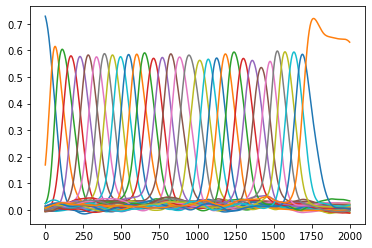

In [29]:
for overlap in overlaps:
    plt.plot(overlap)

In [56]:
np.sqrt(dt/0.01)*sigma_lif_E

0.6172719568183881

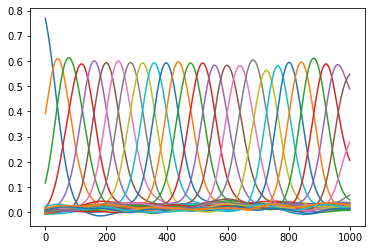

In [53]:
for overlap in overlaps:
    plt.plot(overlap)

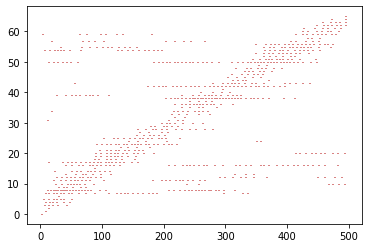

In [22]:
times = np.asarray([np.argmax(r[:]) for r in rate_exc])
idxs = np.arange(times.size)[np.argsort(times)]
active_mask = [np.any(r[:] > 0.0) for r in rate_exc[idxs]]
active_idxs = idxs[active_mask]
x, y = np.nonzero(spks_exc[active_idxs,:].T[:,::200])
plt.scatter(
     x,
     y,
     s=1,
     c="indianred",
     marker='|',
     rasterized=True)

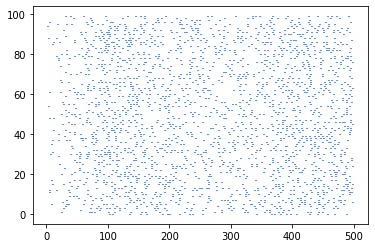

In [17]:
x, y = np.nonzero(spks_inh.T[:,::50])
plt.scatter(
    x,
    y,
    s=1,
    c="royalblue",
    marker='|',
    rasterized=True)

Save data

In [30]:
np.save(
    open("7-spiking/data/slow.npy", "wb"),
    [overlaps,
     v_exc, rate_exc, spks_exc,
     v_inh, rate_inh, spks_inh,
	 exc.thresh])

/hpc/home/mhg19/miniconda3/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)
